In [2]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
# %matplotlib notebook
from sklearn.cluster import KMeans

import sys
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
import os
from scipy.integrate import odeint
#change path to where 'manuscript_data' is saved
dir_path = '/home/antonio/Repositories/manuscript_data/'
sys.path.append(dir_path+'/code/utils/')
import operator_calculations as op_calc
import delay_embedding as embed
import worm_dynamics as worm_dyn
import stats
import clustering_methods as cl
from sklearn.linear_model import LinearRegression
colors_state_=plt.rcParams['axes.prop_cycle'].by_key()['color'][:10]

In [3]:
mat=h5py.File(dir_path+'Foraging/ForagingData/PNAS2011-DataStitched.mat','r')

refs=list(mat['#refs#'].keys())[1:]
tseries_w=[ma.masked_invalid(np.array(mat['#refs#'][ref]).T)[:,:5] for ref in refs]
mat.close()
frameRate=16.
dt=1/frameRate

masked_ts_w = []
for worm in np.arange(len(tseries_w)):
    ts_w = tseries_w[worm]
    ts_w[0] = ma.masked
    ts_w[-1] = ma.masked
    masked_ts_w.append(ts_w)

import worm_dynamics as worm_dyn
segments=op_calc.segment_maskedArray(ma.vstack(masked_ts_w),5)
omegas_all=ma.zeros(ma.vstack(masked_ts_w).shape[0])
a3s_all=ma.zeros(ma.vstack(masked_ts_w).shape[0])
for t0,tf in segments:
    phi,omega,a3=worm_dyn.compute_phi_omega_a3(ma.vstack(masked_ts_w),t0,tf)
    omegas_all[t0:tf] = omega
    a3s_all[t0:tf] = a3
omegas_all[omegas_all==0]=ma.masked
a3s_all[a3s_all==0]=ma.masked

In [4]:
n_clusters=1000
frameRate=16.
dt=1/frameRate

f = h5py.File(dir_path+'Foraging/symbol_sequences/labels_{}_clusters.h5'.format(n_clusters))
labels_traj = ma.array(f['labels_traj'],dtype=int)
mask_traj = np.array(f['mask_traj'],dtype=bool)
labels_phspace = ma.array(f['labels_phspace'],dtype=int)
mask_phspace = np.array(f['mask_phspace'],dtype=bool)
centers_phspace = np.array(f['centers_phspace'])
centers_traj = np.array(f['centers_traj'])
f.close()

labels_traj[mask_traj] = ma.masked
labels_phspace[mask_phspace] = ma.masked

In [4]:
delay = int(.75*frameRate)
print(delay)
# delay=13
lcs,P = op_calc.transition_matrix(labels_traj,delay,return_connected=True)
final_labels = op_calc.get_connected_labels(labels_traj,lcs)
n_modes=10
inv_measure = op_calc.stationary_distribution(P)
R = op_calc.get_reversible_transition_matrix(P)
eigvals,eigvecs = op_calc.sorted_spectrum(R,k=n_modes)
sorted_indices = np.argsort(eigvals.real)[::-1]
eigvals = eigvals[sorted_indices][1:].real
eigvals[np.abs(eigvals-1)<1e-12] = np.nan
eigvals[eigvals<1e-12] = np.nan
t_imp =  -(delay*dt)/np.log(eigvals)

eigfunctions = eigvecs.real/np.linalg.norm(eigvecs.real,axis=0)
eigfunctions_traj = ma.array(eigfunctions)[final_labels,:]
eigfunctions_traj[final_labels.mask] = ma.masked

phi2 = eigfunctions[:,1]

12


In [5]:
n_final_states=2
labels_tree = op_calc.recursive_partitioning_optimal(final_labels,delay,phi2,inv_measure,R,n_final_states)

1
1 [0.9058013610201572, 0.7152434371969076] [0.24603384630523925, 0.7539661536947606]


In [6]:
worms = np.arange(12)
len_w = 33600
ensemble_labels_w=[]
for worm in worms:
    ensemble_labels_w.append(labels_traj[len_w*worm:len_w*(worm+1)])

In [7]:
sims_w = []
f = h5py.File(dir_path+'Foraging/ForagingData/symbol_sequence_simulations.h5','r')
for worm in worms:
    sims = np.array(f['{}/sims'.format(worm)],dtype=int)
    sims_w.append(sims)
f.close()

In [8]:
def bootstrap_rates(l,n_times,confidence_interval=95):
    per=(100-confidence_interval)/2
    new_means=[]
    for i in range(n_times):
        indices=np.random.choice(range(0,len(l)),len(l))
        new_list=[l[idx] for idx in indices]
        new_means.append(ma.mean(new_list,axis=0))
    new_means=ma.vstack(new_means)
    cil=np.zeros(new_means.shape[1])
    ciu=np.zeros(new_means.shape[1])
    for i in range(new_means.shape[1]):
        cil[i]=np.nanpercentile(1/new_means[:,i].filled(np.nan),per)
        ciu[i]=np.nanpercentile(1/new_means[:,i].filled(np.nan),100-per)
    cil = ma.masked_array(cil, np.isnan(cil))
    ciu = ma.masked_array(ciu, np.isnan(ciu))
    return 1/ma.mean(l,axis=0),cil,ciu

In [9]:
n_states=2

mfpt_data_w = np.zeros((len(worms),2,3))
mfpt_sim_w = np.zeros((len(worms),2,3))
rates_data_w = np.zeros((len(worms),2,3))
rates_sim_w = np.zeros((len(worms),2,3))

for worm in worms:
    labels = ensemble_labels_w[worm]
    sims = sims_w[worm]

    cluster_labels = labels_tree[n_states-2,:]
    sims_lifetimes = [stats.state_lifetime(ma.array(cluster_labels[sim]),delay*dt) for sim in sims]

    cluster_traj = ma.copy(labels)
    cluster_traj[~labels.mask] = ma.array(cluster_labels)[labels[~labels.mask]]
    cluster_traj[labels.mask] = ma.masked

    data_lifetimes = stats.state_lifetime(cluster_traj[::delay],delay*dt)

    for state_idx in range(2):
        mfpt_data_w[worm,state_idx,:] = np.hstack(stats.bootstrap(data_lifetimes[state_idx],n_times=1000))
        rates_data_w[worm,state_idx,:] = np.hstack(bootstrap_rates(data_lifetimes[state_idx],n_times=1000))
        all_sim_means = [np.mean(sims_lifetimes[k][state_idx]) for k in range(len(sims_lifetimes))]
        mfpt_sim_w[worm,state_idx,:] = np.mean(all_sim_means),np.percentile(all_sim_means,2.5),np.percentile(all_sim_means,97.5)
        all_sim_rate_means = [1/np.mean(sims_lifetimes[k][state_idx]) for k in range(len(sims_lifetimes))]
        mean_sim_rate = 1/np.hstack([sims_lifetimes[k][state_idx] for k in range(len(sims_lifetimes))]).mean()
        rates_sim_w[worm,state_idx,:] = mean_sim_rate,np.percentile(all_sim_rate_means,2.5),np.percentile(all_sim_rate_means,97.5)
        
    print(worm)

0
1
2
3
4
5
6
7
8
9
10
11


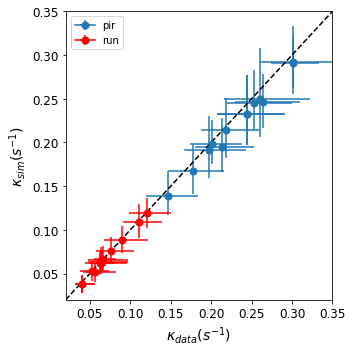

In [10]:
state_idx=0
plt.figure(figsize=(5,5))
for worm in worms:
    mean,cil,ciu = rates_data_w[worm][state_idx]
    mean_s,cil_s,ciu_s = rates_sim_w[worm][state_idx]
    plt.errorbar(mean,mean_s,xerr=[[mean-cil],[ciu-mean]],yerr=[[mean_s-cil_s],[ciu_s-mean_s]],c=colors_state_[state_idx],capsize=0,marker='o',markersize=7)
plt.errorbar(mean,mean_s,xerr=[[mean-cil],[ciu-mean]],yerr=[[mean_s-cil_s],[ciu_s-mean_s]],c=colors_state_[state_idx],capsize=0,marker='o',markersize=7,label='pir')


state_idx=1
# plt.figure(figsize=(5,5))
for worm in worms:
    mean,cil,ciu = rates_data_w[worm][state_idx]
    mean_s,cil_s,ciu_s = rates_sim_w[worm][state_idx]
    plt.errorbar(mean,mean_s,xerr=[[mean-cil],[ciu-mean]],yerr=[[mean_s-cil_s],[ciu_s-mean_s]],c='red',capsize=0,marker='o',markersize=7)
plt.errorbar(mean,mean_s,xerr=[[mean-cil],[ciu-mean]],yerr=[[mean_s-cil_s],[ciu_s-mean_s]],c='red',capsize=0,marker='o',markersize=7,label='run')

xrange=np.linspace(.02,.5,2)
plt.plot(xrange,xrange,c='k',ls='--')
# plt.axis('equal')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(.02,.35)
plt.ylim(.02,.35)
plt.ylabel(r'$\kappa_{sim}(s^{-1})$',fontsize=14)
plt.xlabel(r'$\kappa_{data}(s^{-1})$',fontsize=14)
plt.legend()
plt.tight_layout()
# plt.savefig('rate_both_states.pdf')# plt.xlim(5,35)
# plt.ylim(5,35)
plt.show()

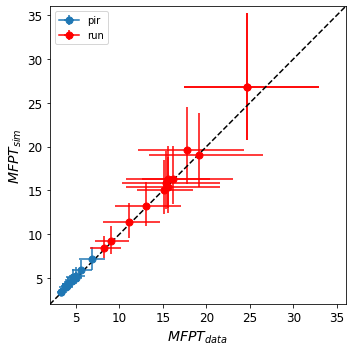

In [11]:
state_idx=0
plt.figure(figsize=(5,5))
for worm in worms:
    mean,cil,ciu = mfpt_data_w[worm][state_idx]
    mean_s,cil_s,ciu_s = mfpt_sim_w[worm][state_idx]
    plt.errorbar(mean,mean_s,xerr=[[mean-cil],[ciu-mean]],yerr=[[mean_s-cil_s],[ciu_s-mean_s]],c=colors_state_[state_idx],capsize=0,marker='o',markersize=7)
plt.errorbar(mean,mean_s,xerr=[[mean-cil],[ciu-mean]],yerr=[[mean_s-cil_s],[ciu_s-mean_s]],c=colors_state_[state_idx],capsize=0,marker='o',markersize=7,label='pir')

state_idx=1
# plt.figure(figsize=(5,5))
for worm in worms:
    mean,cil,ciu = mfpt_data_w[worm][state_idx]
    mean_s,cil_s,ciu_s = mfpt_sim_w[worm][state_idx]
    plt.errorbar(mean,mean_s,xerr=[[mean-cil],[ciu-mean]],yerr=[[mean_s-cil_s],[ciu_s-mean_s]],c='red',capsize=0,marker='o',markersize=7)
plt.errorbar(mean,mean_s,xerr=[[mean-cil],[ciu-mean]],yerr=[[mean_s-cil_s],[ciu_s-mean_s]],c='red',capsize=0,marker='o',markersize=7,label='run')

xrange=np.arange(2,40)
plt.legend()
plt.plot(xrange,xrange,c='k',ls='--')
# plt.axis('equal')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(2,36)
plt.ylim(2,36)
plt.ylabel('$MFPT_{sim}$',fontsize=14)
plt.xlabel('$MFPT_{data}$',fontsize=14)
plt.tight_layout()
# plt.savefig('mfpt_both_states.pdf')
plt.show()